In [1]:
import os
import cv2
import numpy as np
from tqdm import tqdm
import torch
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim


In [2]:
class Data():
    # config
    IMG_SIZE = 200
    NORMAL = 'NORMAL'
    PNEUMONIA = 'PNEUMONIA'
    LABELS = {NORMAL: 0, PNEUMONIA: 1}
    training_data = []
    dataset_path = '/media/abdul/storage/datasets/chest_xray/train'
    IMG_LIMIT = 1300
    NORMAL_IMG_COUNT = 0
    PNEUMONIA_IMG_COUNT = 0
    
    # helper function to make traing data 
    def make_training_data(self):
        for label in self.LABELS:
            i = 0
            for file in tqdm(os.listdir(os.path.join(self.dataset_path, label)),leave=True, position=0):
                if i > self.IMG_LIMIT:
                    break
                try :
                    img_path = os.path.join(self.dataset_path,label,file)
                    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
                    img = cv2.resize(img, (self.IMG_SIZE, self.IMG_SIZE))
                    if label == self.NORMAL:
                        self.NORMAL_IMG_COUNT += 1
                    else :
                        self.PNEUMONIA_IMG_COUNT += 1
                    i += 1
                    self.training_data.append([np.array(img), np.eye(2)[self.LABELS[label]]])
                except Exception as e:
                    pass
        np.random.shuffle(self.training_data)
        np.save("training_data.npy", self.training_data)
    
    def load_data(self):
        training_data = np.load("training_data.npy", allow_pickle=True)
        train_images = torch.Tensor([i[0] for i in training_data]).view(-1,200,200)
        train_images = train_images/255.0
        train_labels = torch.Tensor([i[1] for i in training_data])
        return train_images, train_labels

In [3]:
print(torch.cuda.current_device())
print(torch.cuda.device(0))
print(torch.cuda.get_device_name(0))
print(torch.cuda.is_available())

0
GeForce GTX 1660
True


In [4]:
data = Data()
x, y = data.load_data()

tensor([0., 1.])


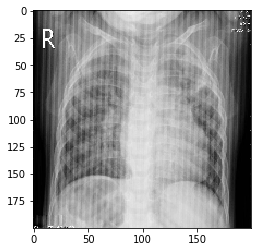

In [5]:
plt.imshow(x[0], cmap = 'gray')
print(y[0])

In [6]:
class Net(nn.Module):
    VAL_PCT = 0.1
    def __init__(self):
        super().__init__()
        self.conv_1 = nn.Conv2d(1, 32, 5)
        self.conv_2 = nn.Conv2d(32, 64, 5)
        self.conv_3 = nn.Conv2d(64, 128, 5)
        
        x = torch.randn(200,200).view(-1,1,200,200)
        self._to_linear = 56448
        #self.convs(x)
        
        self.fc1 = nn.Linear(self._to_linear, 512) 
        self.fc2 = nn.Linear(512, 2)
        
    def convs(self, x):
        x = F.max_pool2d(F.relu(self.conv_1(x)), (2, 2))
        x = F.max_pool2d(F.relu(self.conv_2(x)), (2, 2))
        x = F.max_pool2d(F.relu(self.conv_3(x)), (2, 2))
        if self._to_linear is None:
            self._to_linear = x[0].shape[0]*x[0].shape[1]*x[0].shape[2]
            print(self._to_linear)
        return x
    
    def forward(self, x):
        x = self.convs(x)
        x = x.view(-1, self._to_linear)
        x = F.relu(self.fc1(x))
        x = self.fc2(x) 
        return F.softmax(x, dim=1)

In [7]:
net = Net().cuda()

In [8]:
optimizer = optim.Adam(net.parameters(), lr=0.001)
loss_function = nn.MSELoss()

In [9]:
VAL_PCT = 0.1  # lets reserve 10% of our data for validation
val_size = int(len(x)*VAL_PCT)

train_X = x[:-val_size]
train_y = y[:-val_size]

test_X = x[-val_size:]
test_y = y[-val_size:]

In [17]:
BATCH_SIZE = 64
EPOCHS = 10

for epoch in range(EPOCHS):
    for i in tqdm(range(0, len(train_X), BATCH_SIZE),leave=True, position=0):
        batch_X = train_X[i:i+BATCH_SIZE].view(-1, 1, 200, 200).cuda()
        batch_y = train_y[i:i+BATCH_SIZE].cuda()

        net.zero_grad()

        outputs = net(batch_X)
        loss = loss_function(outputs, batch_y)
        loss.backward()
        optimizer.step()    # Does the update

print(f"Epoch: {epoch+1}. Loss: {loss}")

100%|██████████| 37/37 [00:05<00:00,  6.79it/s]


Epoch: 10. Loss: 0.026312919333577156


In [18]:
correct = 0
total = 0
with torch.no_grad():
    for i in tqdm(range(len(test_X))):
        real_class = torch.argmax(test_y[i].cuda())
        net_out = net(test_X[i].view(-1, 1, 200, 200).cuda())[0]  # returns a list, 
        predicted_class = torch.argmax(net_out)

        if predicted_class == real_class:
            correct += 1
        total += 1
print("Accuracy: ", round(correct/total, 3))

100%|██████████| 260/260 [00:00<00:00, 424.61it/s]

Accuracy:  0.985


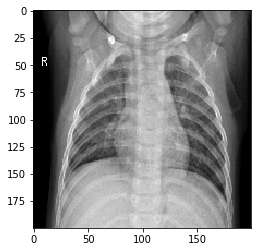

In [21]:
plt.imshow(test_X[0], cmap='gray' )